# PETs Prize Challenge

Pandemic Forecasting Track Partitioning Example

Last Updated: January 6, 2023

This notebook demonstrates how to generate an example partition for the Pandemic Forecasting Track of the PETs Prize Challenge:
- [U.S. Link](https://www.drivendata.org/competitions/103/nist-federated-learning-2-pandemic-forecasting-federated)
- [U.K. Link](https://www.drivendata.org/competitions/141/uk-federated-learning-2-pandemic-forecasting-federated/)

The partitions should be organized in a `data` directory following the schema specified in the [runtime repo](https://github.com/drivendataorg/pets-prize-challenge-runtime#data-1). The following example shows what the `data` directory would look like with 3 partitions:


```
❯ tree data/pandemic/scenario01
data/pandemic/scenario01
├── test
│   ├── client01
│   │   ├── predictions_format.csv
│   │   ├── va_activity_location_assignment.csv.gz
│   │   ├── va_activity_locations.csv.gz
│   │   ├── va_disease_outcome_training.csv.gz
│   │   ├── va_household.csv.gz
│   │   ├── va_person.csv.gz
│   │   ├── va_population_network.csv.gz
│   │   └── va_residence_locations.csv.gz
│   ├── client02
│   │   ├── predictions_format.csv
│   │   ├── va_activity_location_assignment.csv.gz
│   │   ├── va_activity_locations.csv.gz
│   │   ├── va_disease_outcome_training.csv.gz
│   │   ├── va_household.csv.gz
│   │   ├── va_person.csv.gz
│   │   ├── va_population_network.csv.gz
│   │   └── va_residence_locations.csv.gz
│   ├── client03
│   │   ├── ...
│   └── partitions.json
└── train
    ├── client01
    │   ├── va_activity_location_assignment.csv.gz
    │   ├── va_activity_locations.csv.gz
    │   ├── va_disease_outcome_training.csv.gz
    │   ├── va_household.csv.gz
    │   ├── va_person.csv.gz
    │   ├── va_population_network.csv.gz
    │   └── va_residence_locations.csv.gz
    ├── client02
    │   ├── va_activity_location_assignment.csv.gz
    │   ├── va_activity_locations.csv.gz
    │   ├── va_disease_outcome_training.csv.gz
    │   ├── va_household.csv.gz
    │   ├── va_person.csv.gz
    │   ├── va_population_network.csv.gz
    │   └── va_residence_locations.csv.gz
    ├── client03
    │   ├── ...
    └── partitions.json
```

Note that "feature" data csvs appear in both train and test data. However, test data will have an additional csv, `predictions_format.csv`, that will specify the index and columns of your predictions.

For more information on how to generate and test your federated solutions, check out the federated code submission pages:
- [U.S. Federated Code Submission Page](https://www.drivendata.org/competitions/103/nist-federated-learning-2-pandemic-forecasting-federated/page/581/)
- [U.K. Federated Code Submission Page](https://www.drivendata.org/competitions/141/uk-federated-learning-2-pandemic-forecasting-federated/page/643/)

Let's get started!

## Import libraries

In [1]:
from collections import defaultdict
from pathlib import Path

import numpy as np
import pandas as pd

## Fetch and inspect data

In this example, we'll be partitioning the Phase 1 Virginia (VA) development dataset. For Phase 2 evaluation, we'll be using the VA dataset for both U.S. and U.K. competitions.

In [2]:
# Read from local data path
DATA = Path.cwd() / "../data/"
FINAL = DATA / "final" / "phase_1" / "pandemic_forecasting" / "compressed"

In [3]:
# Import and inspect residence, household, and person tables
residence_locations_df = pd.read_csv(FINAL / "va_residence_locations.csv.gz")
household_df = pd.read_csv(FINAL / "va_household.csv.gz")
person_df = pd.read_csv(FINAL / "va_person.csv.gz")
person_df = person_df.merge(
    right=household_df[["hid", "admin2"]],
    on="hid",
    how="inner",
)

In [4]:
residence_locations_df.head()

,rlid,longitude,latitude,admin1,admin2
0,1000000001,-75.486497,38.000083,51,1
1,1000000002,-75.473003,37.997079,51,1
2,1000000003,-75.471243,37.997374,51,1
3,1000000004,-75.424909,38.009950,51,1
4,1000000005,-75.415167,38.001239,51,1


In [5]:
household_df.head()

,hid,rlid,admin1,admin2,hh_size
0,0,1001001400,51,1,2
1,1,1001054289,51,1,2
2,2,1001317942,51,1,4
3,3,1001581554,51,1,2
4,4,1001819627,51,1,2


In [6]:
person_df.head()

,hid,pid,person_number,age,sex,admin2
0,0,0,1,52,1,1
1,0,1,2,55,2,1
2,1,2,1,50,2,1
3,1,3,2,57,1,1
4,2,4,1,33,2,1


In [7]:
# How many unique counties are there?
print(household_df.admin2.nunique())
household_df.admin2.unique()

133


array([  1,   3,   5,   7,   9,  11,  13,  15,  17,  19,  21,  23,  25,
        27,  29,  31,  33,  35,  36,  37,  41,  43,  45,  47,  49,  51,
        53,  57,  59,  61,  63,  65,  67,  69,  71,  73,  75,  77,  79,
        81,  83,  85,  87,  89,  91,  93,  95,  97,  99, 101, 103, 105,
       107, 109, 111, 113, 115, 117, 119, 121, 125, 127, 131, 133, 135,
       137, 139, 141, 143, 145, 147, 149, 153, 155, 157, 159, 161, 163,
       165, 167, 169, 171, 173, 175, 177, 179, 181, 183, 185, 187, 191,
       193, 195, 197, 199, 510, 520, 530, 540, 550, 570, 580, 590, 595,
       600, 610, 620, 630, 640, 650, 660, 670, 678, 680, 683, 685, 690,
       700, 710, 720, 730, 735, 740, 750, 760, 770, 775, 790, 800, 810,
       820, 830, 840])

## Generate partitions

In practice, partitions should:
- contain counties that are geographically close
- be of roughly equal size by population

We've created one such partitioning below. We've also included a function to randomly generation partitions that _do not_ meet these requirements, in case you want to quickly test your solution with n partitions.

In [8]:
# Plot geographical centroids
admin2_centroids_df = residence_locations_df.groupby("admin2").agg(
    longitude=("longitude", "mean"), latitude=("latitude", "mean")
)
admin2_centroids_df

,longitude,latitude
admin2,,
1,-75.617895,37.796605
3,-78.526600,38.048899
5,-79.946224,37.795066
7,-77.978057,37.341514
9,-79.103933,37.532631
...,...,...
800,-76.568417,36.768444
810,-76.096160,36.816578
820,-78.897132,38.071925


<AxesSubplot: xlabel='longitude', ylabel='latitude'>

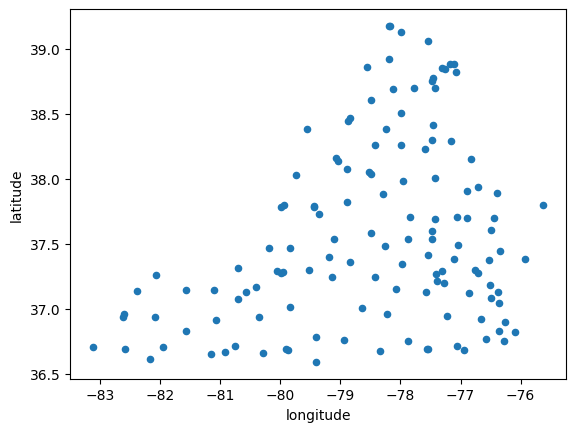

In [9]:
admin2_centroids_df.plot.scatter(x="longitude", y="latitude")

Let's generate 3 partitions with counties that are geographically close together using the latitude and longitude of the county centroids.

<AxesSubplot: xlabel='longitude', ylabel='latitude'>

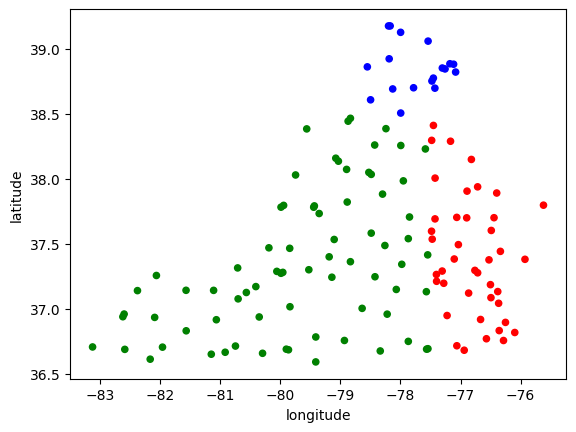

In [10]:
def assign_partition(row):
    LAT_THRESH = 38.5
    LON_THRESH = -77.5

    if row.latitude >= LAT_THRESH:
        return "client01"
    if row.longitude < LON_THRESH:
        return "client02"
    return "client03"


# Assign partitions
admin2_centroids_df["partition"] = admin2_centroids_df.apply(assign_partition, axis=1)

# Plot partitions
cmap = dict(zip(admin2_centroids_df.partition.unique(), ("red", "green", "blue")))
admin2_centroids_df.plot.scatter(
    x="longitude", y="latitude", c=admin2_centroids_df.partition.map(cmap)
)

Let's inspect the population counts of each partition. Remember we want them to be approximately equal.

In [11]:
person_df.admin2.map(
    admin2_centroids_df.partition.to_dict()
).value_counts().sort_index()

client01    2609976
client02    2466650
client03    2611433
Name: admin2, dtype: int64

Looks good enough! Let's stick with these.

For a different number of partitions, you'll need to come up with additional ways of segmenting counties. If you'd like to quickly test your solution with `n` partitions, you can generate less realistic random partitions using the function below.

In [12]:
def randomly_partition_counties(n: int, counties: iter) -> dict:
    """Helper function to quickly generate random partitions for testing.
    Note that this does not generate realistic partitions that will be used
    for evaluation.

    Args:
        n (int): number of partitions
        counties (iter): The complete set of `admin2` (county) IDs

    Returns:
        Dict where the keys are partition IDs and the values are a set of `admin2` (county) IDs
    """
    # Set seed
    np.random.seed(8)

    # randomly assign counties to partitions
    partition_ids = [(i % n) + 1 for i in range(len(counties))]
    np.random.shuffle(partition_ids)
    county_to_partition = dict(zip(counties, partition_ids))

    # invert dictionary
    partition_to_counties = defaultdict(set)
    for county, partition in county_to_partition.items():
        partition_to_counties[f"client{partition:02}"].add(county)

    return partition_to_counties


# test and inspect
counties = household_df.admin2.unique()
rand_partition_to_counties = randomly_partition_counties(10, counties)

for partition in sorted(rand_partition_to_counties):
    print(f"{partition} (len = {len(rand_partition_to_counties[partition])})")
    print(f"{rand_partition_to_counties[partition]}\n")

client01 (len = 14)
{770, 35, 99, 163, 73, 79, 175, 81, 53, 21, 57, 187, 61, 127}

client02 (len = 14)
{197, 7, 520, 107, 620, 590, 111, 83, 51, 183, 121, 700, 157, 191}

client03 (len = 14)
{1, 33, 65, 167, 199, 139, 45, 109, 660, 117, 181, 570, 29, 31}

client04 (len = 13)
{195, 580, 37, 101, 41, 650, 685, 47, 720, 820, 600, 27, 63}

client05 (len = 13)
{97, 153, 36, 133, 740, 103, 840, 810, 173, 15, 147, 25, 670}

client06 (len = 13)
{67, 71, 775, 75, 43, 750, 690, 85, 87, 185, 91, 830, 159}

client07 (len = 13)
{640, 161, 193, 550, 137, 13, 141, 143, 115, 23, 540, 93, 510}

client08 (len = 13)
{3, 131, 69, 135, 11, 155, 171, 17, 177, 530, 735, 59, 95}

client09 (len = 13)
{800, 610, 165, 678, 169, 683, 77, 113, 179, 149, 630, 119, 730}

client10 (len = 13)
{5, 710, 680, 9, 105, 49, 145, 19, 595, 790, 760, 89, 125}



## Data Preparation

### Construct sets of relevant household and person IDs for each partition

In [13]:
# Create a map of our partitions to facilitate partitioning
partition_to_counties = (
    admin2_centroids_df.reset_index().groupby("partition").admin2.apply(set).to_dict()
)

In [14]:
partition_to_hids = {}
partition_to_pids = {}

for partition_id, counties in partition_to_counties.items():
    partition_to_hids[partition_id] = set(
        household_df[household_df["admin2"].isin(counties)].hid
    )
    partition_to_pids[partition_id] = set(
        person_df[person_df["admin2"].isin(counties)].pid
    )

In [15]:
# Free up memory
del residence_locations_df
del household_df
del person_df

## Partition data

First, let's create directories for each partition as specified in the [runtime repo](https://github.com/drivendataorg/pets-prize-challenge-runtime#data-1), e.g.:

```
data/pandemic/scenario01
├── test
│   ├── client01
│   │   ├── ...
│   ├── ...
│   └── partitions.json
└── train
    ├── client01
    │   ├── ...
    ├── ...
    └── partitions.json
```

In [16]:
OUT_DIR = DATA / "pandemic" / "scenario01"
TEST = OUT_DIR / "test"
TRAIN = OUT_DIR / "train"

for partition in partition_to_counties:
    (TEST / partition).mkdir(exist_ok=True, parents=True)
    (TRAIN / partition).mkdir(exist_ok=True, parents=True)

### Partition data based on household ID or person ID

Counties within a partition have access to all information for all residents within the partition's counties, including residences, persons, and activity assignments. This is true even if an activity occurs in a county outside of that partition.

In [17]:
def partition_by_id(
    df: pd.DataFrame,
    partition_to_ids: dict,
    id_col: str,
    out_dirs: list[Path],
    filename: str,
) -> None:
    """Partitions a dataframe according to a set of IDs and writes out to disk

    Args:
        df (pd.DataFrame): The dataframe to partition
        partition_to_ids (dict): A dictionary where the keys are the partition name and
            the values are a set of IDs
        id_col (str): The name of the column in `df` designating the ID to partition on
        out_dir (List[Path]): A list of directories to write out the partitions to
        filename (str): The filename of the partitioned csv.

    Returns:
        None
    """
    for partition, ids in partition_to_ids.items():
        part = df[df[id_col].isin(ids)]
        for out_dir in out_dirs:
            out_file = out_dir / str(partition) / filename
            print(f"Writing {out_file.relative_to(out_file.parents[3])}...")
            compression = "gzip" if filename.endswith("gz") else None
            part.to_csv(out_file, index=False, compression=compression)


# partition datasets that rely on pid-only
for dataset in [
    "va_person.csv.gz",
    "va_disease_outcome_training.csv.gz",
    "va_activity_location_assignment.csv.gz",
]:
    partition_by_id(
        pd.read_csv(FINAL / dataset), partition_to_pids, "pid", [TEST, TRAIN], dataset
    )

# partition datasets that rely on hid-only
dataset = "va_household.csv.gz"
partition_by_id(
    pd.read_csv(FINAL / dataset), partition_to_hids, "hid", [TEST, TRAIN], dataset
)

Writing scenario01/test/client01/va_person.csv.gz...
Writing scenario01/train/client01/va_person.csv.gz...
Writing scenario01/test/client02/va_person.csv.gz...
Writing scenario01/train/client02/va_person.csv.gz...
Writing scenario01/test/client03/va_person.csv.gz...
Writing scenario01/train/client03/va_person.csv.gz...
Writing scenario01/test/client01/va_disease_outcome_training.csv.gz...
Writing scenario01/train/client01/va_disease_outcome_training.csv.gz...
Writing scenario01/test/client02/va_disease_outcome_training.csv.gz...
Writing scenario01/train/client02/va_disease_outcome_training.csv.gz...
Writing scenario01/test/client03/va_disease_outcome_training.csv.gz...
Writing scenario01/train/client03/va_disease_outcome_training.csv.gz...
Writing scenario01/test/client01/va_activity_location_assignment.csv.gz...
Writing scenario01/train/client01/va_activity_location_assignment.csv.gz...
Writing scenario01/test/client02/va_activity_location_assignment.csv.gz...
Writing scenario01/train

In [18]:
# Generate and partition a predictions_format.csv
target = pd.read_csv(FINAL / "va_disease_outcome_target.csv.gz")

# Set drop `infected` column and set "score" to a dummy pred of 0.5 for `predictions_format.csv`
target["score"] = 0.5
target = target.drop(columns="infected")

target

,pid,score
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5
...,...,...
7688054,7688054,0.5
7688055,7688055,0.5
7688056,7688056,0.5
7688057,7688057,0.5


In [19]:
# Partition. Should only be written out to `test` directories.
partition_by_id(target, partition_to_pids, "pid", [TEST], "predictions_format.csv")

Writing scenario01/test/client01/predictions_format.csv...
Writing scenario01/test/client02/predictions_format.csv...
Writing scenario01/test/client03/predictions_format.csv...


### Partition datasets based on location

A partition knows about all residences that are located within its counties. Of locations that are outside a partition's counties, the partition knows about:
  - all locations for all of its residents' activities
  
It does *not* know about locations outside of its counties that no residents visit. Additionally, it only knows about **contacts** that occurred outside of the partition's boundaries if and only if the contact occurred between two residents of the partition. Said differently, any contact that occured between residents of different partitions is not known by any partition.

In [20]:
# First, construct the set of relevant location IDs for each partition
# using activity location assignment and residence location tables

def build_partition_to_lids_from_activities(
    activity_loc_assignment_df: pd.DataFrame, partition_to_pids: dict
) -> dict:
    """Generates the set of relevant location IDs for each partition from the activity location assignment table

    Args:
        activity_loc_assignment_df (pd.DataFrame): The activity location assignment dataframe
        partition_to_pids (dict): A dictionary where the keys are the partition name and the values are a set of person IDs

    Returns:
        (dict) A dictionary where the keys are the partition name and the values are sets of location IDs
    """
    partition_to_lids = dict()

    for partition, pids in partition_to_pids.items():
        partition_df = activity_loc_assignment_df[
            activity_loc_assignment_df["pid"].isin(pids)
        ]
        partition_to_lids[partition] = set(partition_df["lid"])

    return partition_to_lids


def build_partition_to_lids_from_locations(
    location_df: pd.DataFrame, partition_to_counties: dict, lid_col: str
) -> dict:
    """Generates the set of relevant location IDs for each partition from a locations table

    Args:
        location_df (pd.DataFrame): The residence or activity locations dataframe
        partition_to_counties (dict): A dictionary where the keys are the partition name and the
            values are the set of relevant counties (`admin2`)

    Returns:
        (dict) A dictionary where the keys are the partition name and the values are sets of location IDs
    """
    partition_to_lids = dict()

    for partition, admin2s in partition_to_counties.items():
        partition_to_lids[partition] = set(
            location_df[location_df.admin2.isin(admin2s)][lid_col]
        )

    return partition_to_lids


partition_to_lids = defaultdict(set)

# iterate through dictionaries to merge
dataset = "va_activity_location_assignment.csv.gz"
for partition, lids in build_partition_to_lids_from_activities(
    pd.read_csv(FINAL / dataset), partition_to_pids
).items():
    partition_to_lids[partition] |= lids

dataset = "va_residence_locations.csv.gz"
for partition, lids in build_partition_to_lids_from_locations(
    pd.read_csv(FINAL / dataset), partition_to_counties, "rlid"
).items():
    partition_to_lids[partition] |= lids

In [21]:
# now partition datasets that rely on lid
dataset = "va_residence_locations.csv.gz"
partition_by_id(pd.read_csv(FINAL / dataset), partition_to_lids, "rlid", [TEST, TRAIN], dataset)

dataset = "va_activity_locations.csv.gz"
partition_by_id(pd.read_csv(FINAL / dataset), partition_to_lids, "alid", [TEST, TRAIN], dataset)

Writing scenario01/test/client01/va_residence_locations.csv.gz...
Writing scenario01/train/client01/va_residence_locations.csv.gz...
Writing scenario01/test/client02/va_residence_locations.csv.gz...
Writing scenario01/train/client02/va_residence_locations.csv.gz...
Writing scenario01/test/client03/va_residence_locations.csv.gz...
Writing scenario01/train/client03/va_residence_locations.csv.gz...
Writing scenario01/test/client01/va_activity_locations.csv.gz...
Writing scenario01/train/client01/va_activity_locations.csv.gz...
Writing scenario01/test/client02/va_activity_locations.csv.gz...
Writing scenario01/train/client02/va_activity_locations.csv.gz...
Writing scenario01/test/client03/va_activity_locations.csv.gz...
Writing scenario01/train/client03/va_activity_locations.csv.gz...


### Finally, partition datasets that are based on contact between two residents

Counties know about all contacts for any two people who reside within the partition's counties, even if contact occurs in a county outside of that partition.

Conversely, network contacts are dropped if they occur between two people who reside in counties that belong to different partitions. It does not matter if the contact occurred in a county that belongs to the partition, so long as at least one of the two people live outside the partition's counties.

In [22]:
def partition_by_contact(
    df: pd.DataFrame, partition_to_pids: dict, out_dirs: list[Path],
    filename: str,
) -> None:
    """Partitions network to contacts that occured between two people living in the same partition

    Args:
        df (pd.DataFrame): The dataframe to partition
        partition_to_pids (dict): A dictionary where the keys are the partition name and the values
            are a set of person IDs
        id_col (str): The name of the column in `df` designating the ID to partition on
        out_dirs (List[Path]): A list of directories to write out the partitions to
        filename (str): The filename of the partitioned csv.

    Returns:
        None
    """
    for partition, pids in partition_to_pids.items():
        for out_dir in out_dirs:
            out_file = out_dir / str(partition) / filename
            print(f"Writing {out_file.relative_to(out_file.parents[3])}...")
            # both individuals need to reside within the partition's counties
            partition_df = df[df["pid1"].isin(pids) & df["pid2"].isin(pids)]
            partition_df.to_csv(out_file, index=False, compression="gzip")    

dataset = "va_population_network.csv.gz"
partition_by_contact(pd.read_csv(FINAL / dataset), partition_to_pids, [TEST, TRAIN], dataset)

Writing scenario01/test/client01/va_population_network.csv.gz...
Writing scenario01/train/client01/va_population_network.csv.gz...
Writing scenario01/test/client02/va_population_network.csv.gz...
Writing scenario01/train/client02/va_population_network.csv.gz...
Writing scenario01/test/client03/va_population_network.csv.gz...
Writing scenario01/train/client03/va_population_network.csv.gz...


### Inspect partitioned files

In [23]:
print(*[f"{f.relative_to(OUT_DIR)}" for f in OUT_DIR.rglob("*.csv*")], sep="\n")

test/client01/va_activity_locations.csv.gz
test/client01/predictions_format.csv
test/client01/va_household.csv.gz
test/client01/va_residence_locations.csv.gz
test/client01/va_person.csv.gz
test/client01/va_activity_location_assignment.csv.gz
test/client01/va_population_network.csv.gz
test/client01/va_disease_outcome_training.csv.gz
test/client02/predictions_format.csv
test/client02/va_activity_locations.csv.gz
test/client02/va_household.csv.gz
test/client02/va_person.csv.gz
test/client02/va_activity_location_assignment.csv.gz
test/client02/va_residence_locations.csv.gz
test/client02/va_population_network.csv.gz
test/client02/va_disease_outcome_training.csv.gz
test/client03/predictions_format.csv
test/client03/va_activity_locations.csv.gz
test/client03/va_household.csv.gz
test/client03/va_activity_location_assignment.csv.gz
test/client03/va_residence_locations.csv.gz
test/client03/va_person.csv.gz
test/client03/va_disease_outcome_training.csv.gz
test/client03/va_population_network.csv.g